# **Metadata:** 
- CustID = ID
- FirstPolYear =  Year of the customer’s first policy
- BirthYear =  Customer’s Birthday Year
- EducYear = Academic Year
- MonthSal =  Gross monthly salary (€)
- GeoLivArea = Living Area
- Children = Binary variable (Y=1)
- CustMonVal = Customer Monetary Value
- ClaimsRate = ClaimsRate
- PremMotor = Premiums (€) in LOB: Motor
- PremHousehold = Premiums (€) in LOB: Household
- PremHealth = Premiums (€) in LOB: Health
- PremLife = Premiums (€) in LOB: Life
- PremWork Compensation = Premiums (€) in LOB: Work Compensation

# **1. Imports the needed libraries and some data exploration**

- **1.1) Imports**
- **1.2) Inicial Exploration**
- 1.2.1) Counting the number of lines 
- 1.2.2) Making a safety copy of the dataset
- 1.2.3) Datatypes
- **1.3) Duplicated Values**
- **1.4) Data Categorization**
- 1.4.1) Metric vs Non Metric Variables
- **1.5) Missing Values**
- 1.5.1) Initial Assessment
- 1.5.2) Apply the Mice algorithm on the metric_features
- 1.5.3) Apply the central tendency on the non_metric_features
- 1.5.3.1) Fillna (modes, inplace=True)

- **1.1) Imports**

In [1]:
# In case this was not previous installed.
# ! conda install graphviz

# Imports
import graphviz
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sqlite3
import pandas as pd
import time

# From Sklearn
from sklearn import linear_model
from sklearn.base import clone
from sklearn.cluster import AgglomerativeClustering, DBSCAN, estimate_bandwidth, KMeans, MeanShift, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# From other libraries
from datetime import datetime
from itertools import product
from math import ceil
from minisom import MiniSom
from os.path import join
from pandas_profiling import ProfileReport
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Reading initial data
folder = 'a2z_insurance.sas7bdat'
df = pd.read_sas(folder)
df.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


- **1.2) Inicial Exploration**

In [2]:
# Count the number of rows.
# Get sensivity on data.

len(df.axes[0]) 

10296

In [3]:
# Make a first security copy of our original dataset.

df_original = df.copy()

In [4]:
# Check dataset data types.

df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

- **1.3) Duplicate Values**

In [5]:
# Check the duplicate values on our dataset.

df.duplicated().sum()

0

- **1.4) Data Categorization**

In [6]:
# Define metric and non-metric features.

non_metric_features = ["EducDeg", "Children", "GeoLivArea"] 
metric_features = df.columns.drop(non_metric_features).to_list()
metric_features

['CustID',
 'FirstPolYear',
 'BirthYear',
 'MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork']

- **1.5) Missing Values**
- 1.5.1) Initial Assessment
- 1.5.2) Apply the Mice algorithm on the metric_features
- 1.5.3) Apply the central tendency on the non_metric_features
- 1.5.3.1) Fillna (modes, inplace=True)

In [7]:
# Check the missing values on our dataset.

df.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [8]:
# Represent a missing values in pandas with a NaN value.

df.replace("", np.nan, inplace=True)

In [9]:
# Check descriptive statistics again before replacing missing values.

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42


In [11]:
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# Apply fit_transform at the same time.
df[metric_features] = mice_imputer.fit_transform(df[metric_features])

In [12]:
# Apply fit_transform at the same time.

# knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
# df[metric_features] = knn_imputer.fit_transform(df[metric_features])

In [13]:
# Check the missing values on our dataset after applying Mice Imputer.
# The remaining missing values are only non metric features, which indicates that all metric features were correctly imputed.

df.isna().sum() 

CustID            0
FirstPolYear      0
BirthYear         0
EducDeg          17
MonthSal          0
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
dtype: int64

In [14]:
# As long as there are only 39 remaining variables, we did not considered it very relevant in the universe 
# of the entire dataset.
# In this sense, we used a less sophisticated metric: mode. 

modes = df[non_metric_features].mode().loc[0]
modes

EducDeg       b'3 - BSc/MSc'
Children                 1.0
GeoLivArea               4.0
Name: 0, dtype: object

In [15]:
# Check the missing values on our dataset after applying mode imputer.

df.fillna(modes, inplace=True)
df.isna().sum() 

CustID           0
FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [16]:
# Check descriptive statistics again after replacing missing values.

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustID,10296.0,NaN,NaN,NaN,5148.5,2972.34352,1.0,2574.75,5148.5,7722.25,10296.0
FirstPolYear,10296.0,NaN,NaN,NaN,1991.06427,510.522485,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10296.0,NaN,NaN,NaN,1968.005833,19.698539,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10296,4,b'3 - BSc/MSc',4816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10296.0,NaN,NaN,NaN,2506.645912,1156.237689,333.0,1706.0,2502.0,3290.0,55215.0
GeoLivArea,10296.0,NaN,NaN,NaN,2.709984,1.266293,1.0,1.0,3.0,4.0,4.0
Children,10296.0,NaN,NaN,NaN,0.707362,0.454996,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10296.0,NaN,NaN,NaN,300.375665,211.805964,-4.11,190.48,298.555,407.52,11604.42


# **2. Taking a graphical look at the distributions**

- **2.1) Metric features**
- 2.1.1) Histograms
- 2.1.2) Box Plots
- **2.2) Non metric features**
- 2.2.1) Histograms

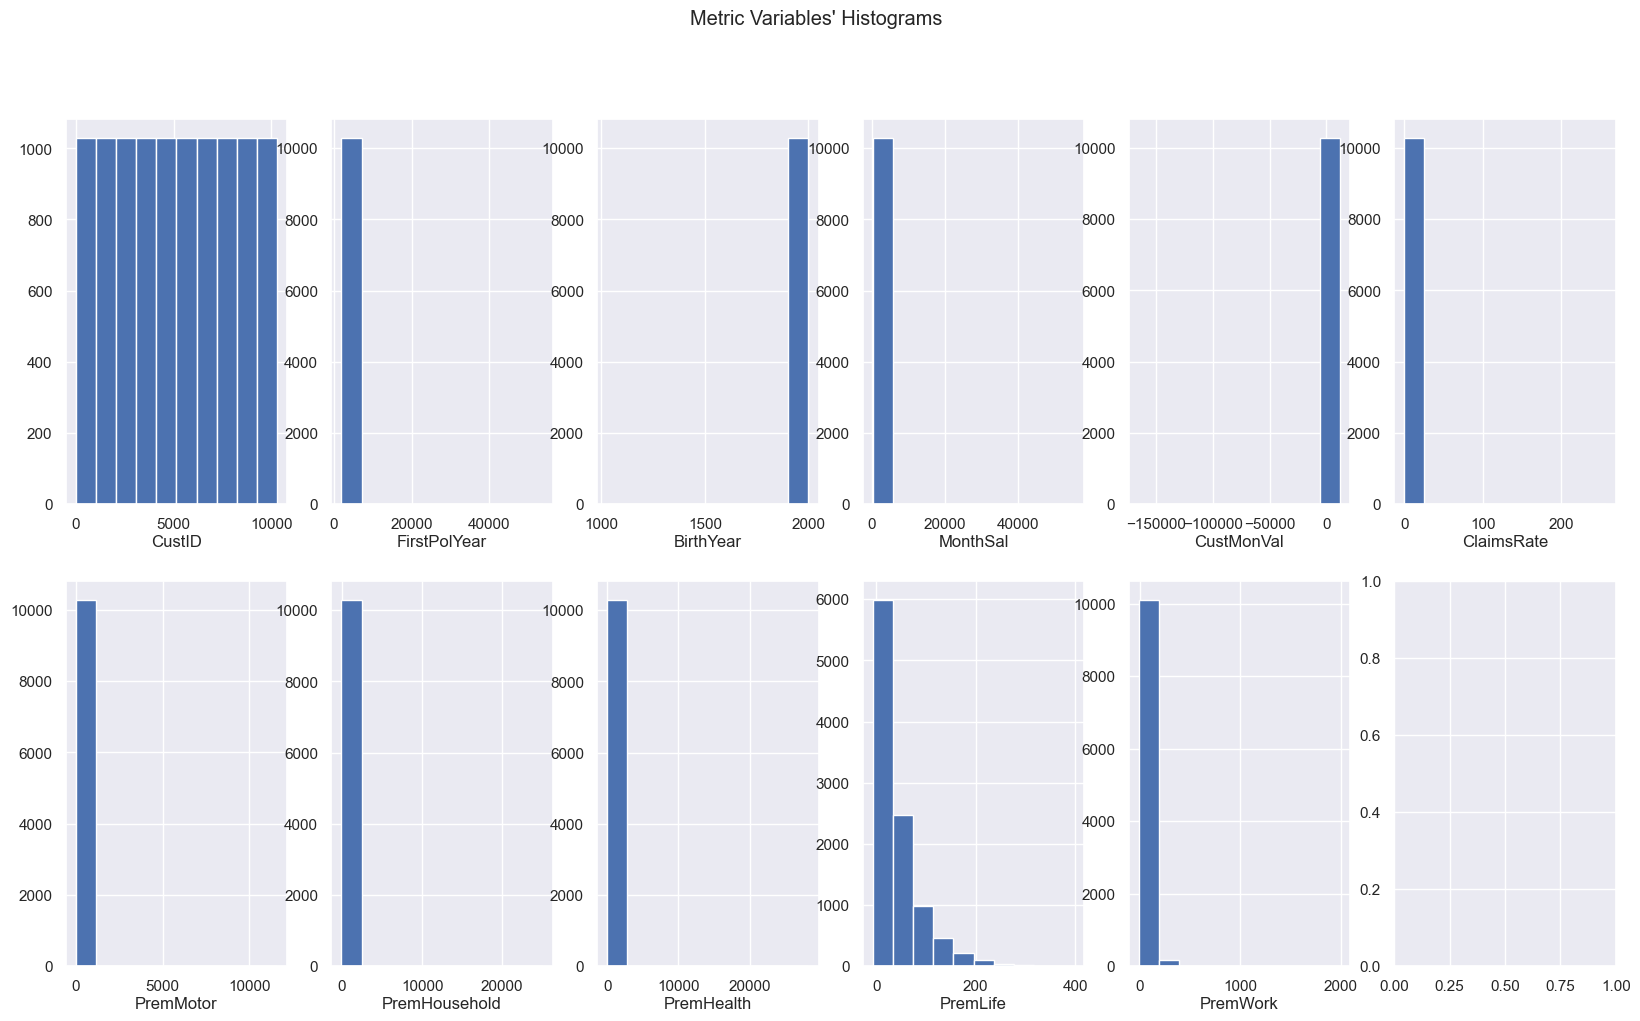

In [17]:
# Get a depper visual understanding on metric features through histograms.

# All Metric Variables' Histograms in one figure.
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

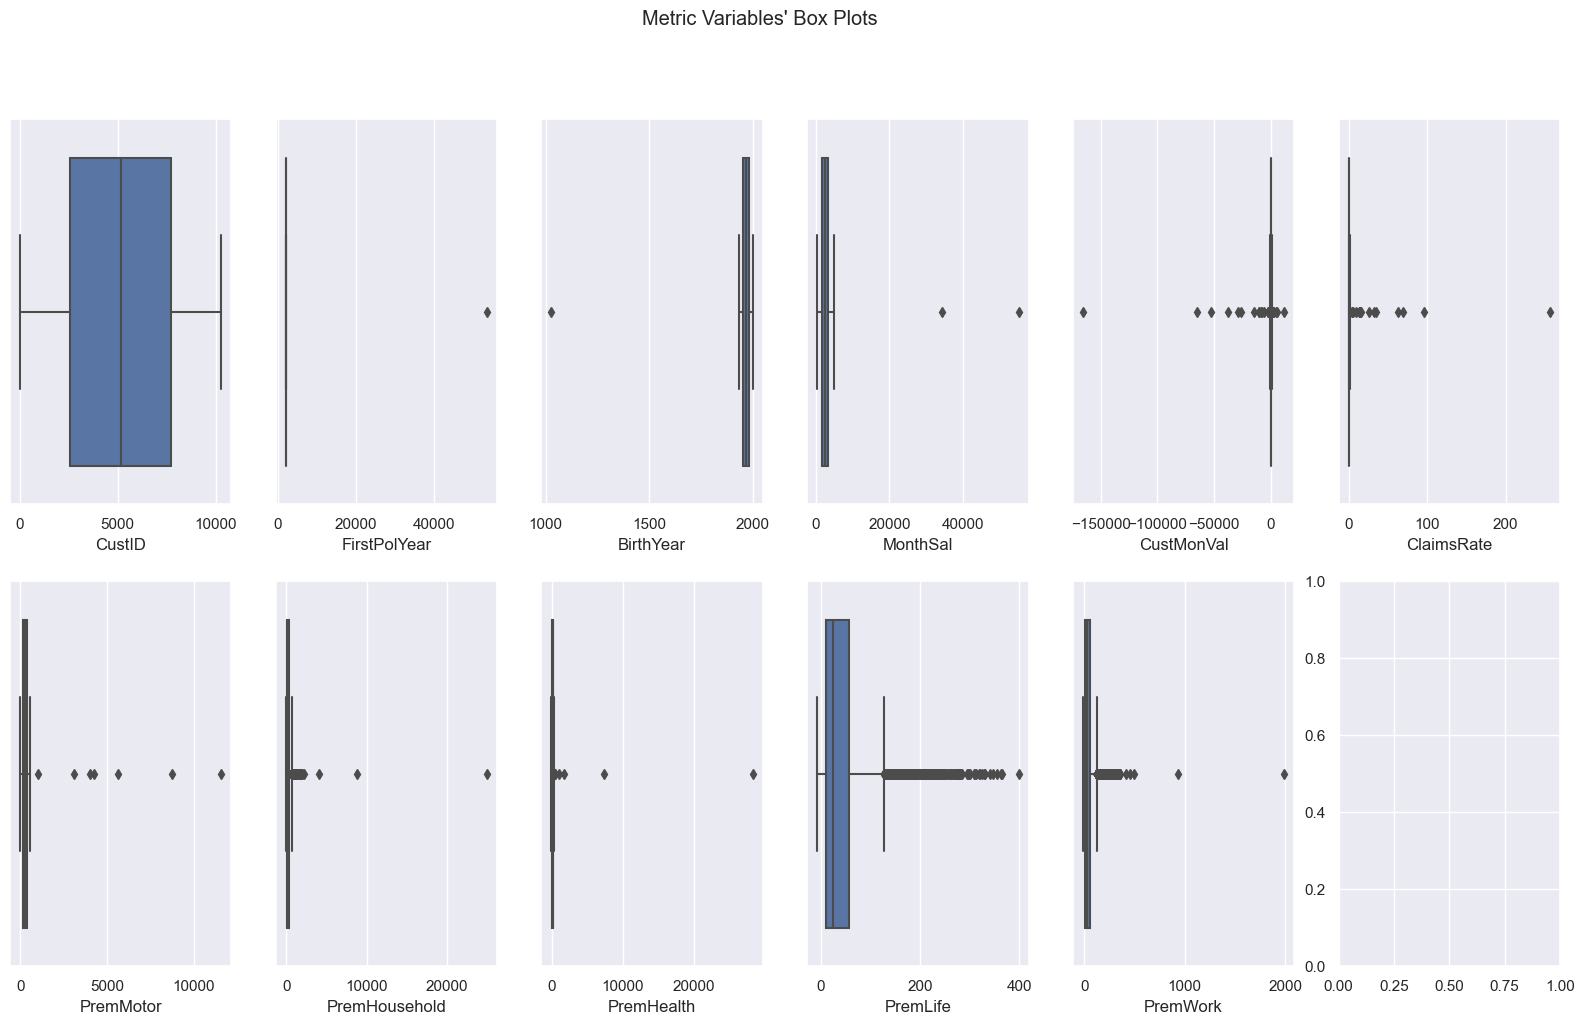

In [18]:
# Get a depper visual understanding on metric features through Box Plots. 
# With this graph, we can have an even better understanding on existing outliers.

# All Metric Variables' Box Plots in one figure.
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

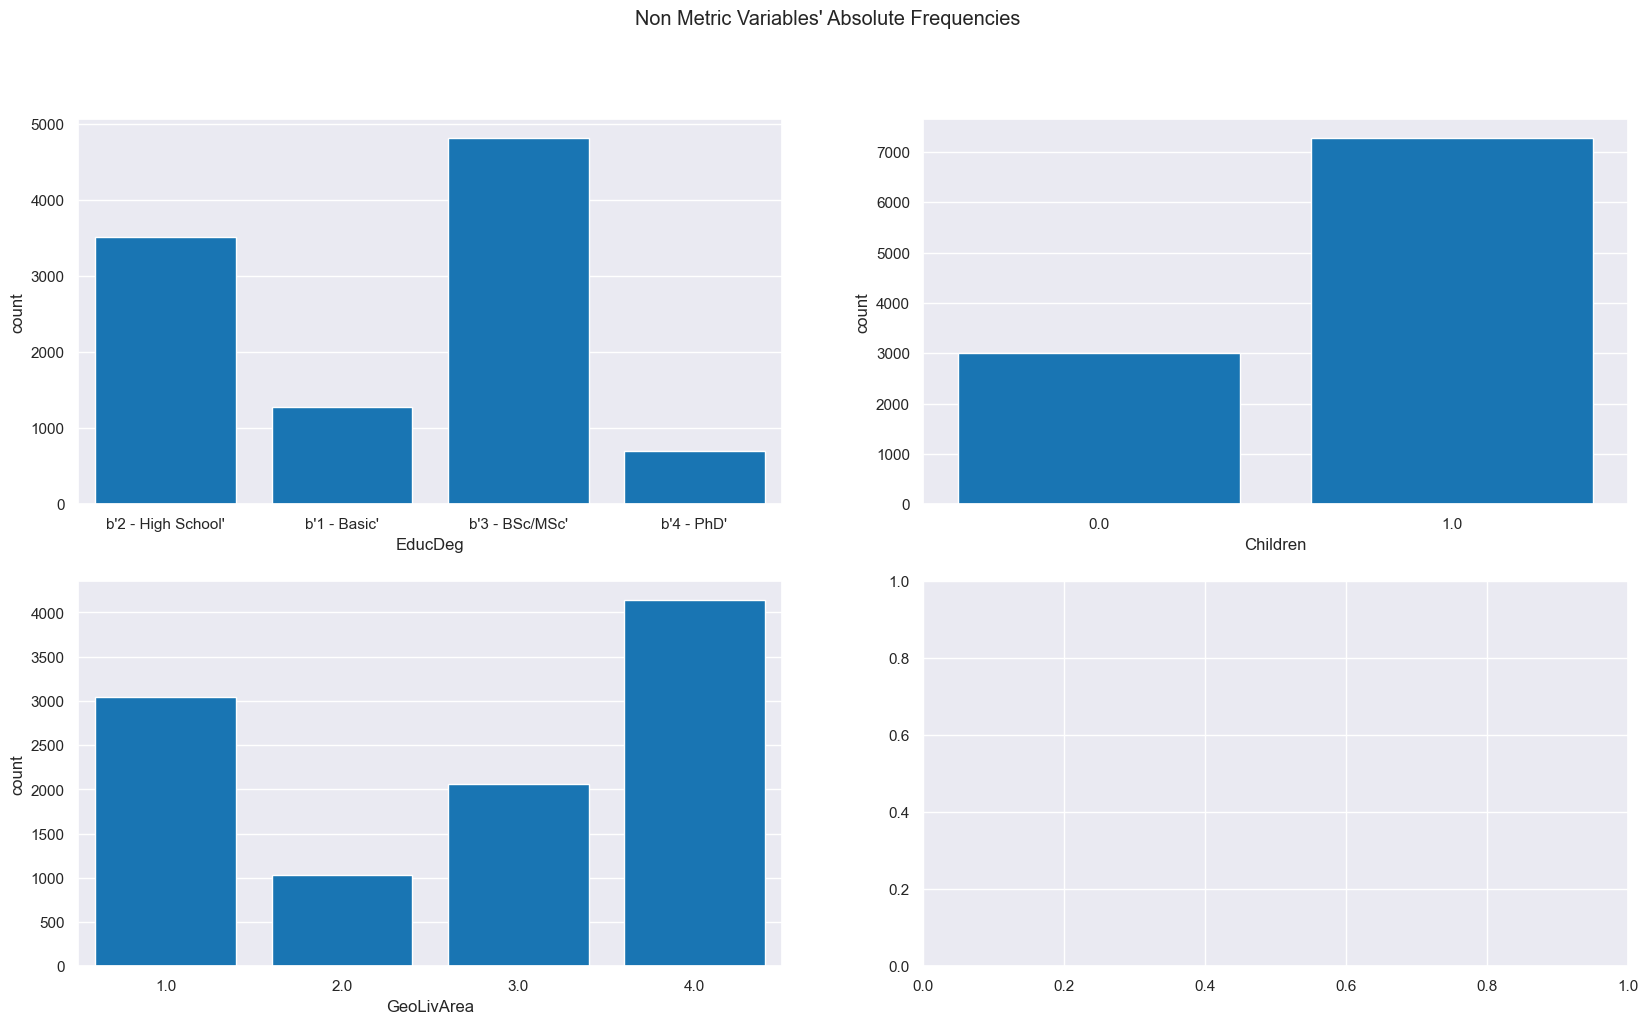

In [19]:
# Get a depper visual understanding on 'non-metric' features through histograms.

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): 
    sns.countplot(x=df[feat].astype(object), ax=ax, color='#007acc')

title = "Non Metric Variables' Absolute Frequencies"
plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

# **3. Outliers**

- **3.1) Manual method on Outlier removal**
- 3.1.1) Check % kept
- **3.2) IQR method on Outlier removal**
- 3.2.1) Check % kept
- **3.3) Combined both previous methods on Outlier removal**
- 3.3.1) Check % kept
- **3.4) Took a final look at the graphs to understand the final positions**
- 3.4.1) Checked histrograms
- 3.4.2) Checked box plots

In [20]:
# Outlier Manual Removal (First method).
    # Here, on outliers manual remotion, we decided to look both at the histograms, at the box plots and at the 
    # descriptive statistics resume.
    # In our opinion, all these three were relevant instruments to filter each variable.
        # So, based on these elements, we mostly adopted a 'try and error aproach'.
    
    # We kept the following variables without filters:
        # CustID
        # EducDeg
        # GeoLivArea
        # Children

filters_1 = (
     (df['BirthYear']>=1900) # Mostly, by looking at the histogram.
     &
     (df['ClaimsRate']<=(1.3))  # Although there are slightly more than some residual observations (above 10, by looking at the box plot), we decided to discart them.
     &    
     (df['CustMonVal']>=(-400)) # Mostly, by looking at the histogram.
     &
     (df['CustMonVal']<=(1150)) # Mostly, by looking at the histogram.
     &
     (df['FirstPolYear']<=(2016)) # Since the current year of the database is 2016.
     &
     (df['MonthSal']<=(7000)) # Mostly, by looking at the histogram.
     &
     (df['PremHealth']<=(380)) # Mostly, by looking at the histogram.
     &
     (df['PremHousehold']<=(1100)) # Mostly, by looking at the histogram.
     &
     (df['PremLife']<=(220)) # Mostly, by looking at the box plot.
     &
     (df['PremMotor']<=(600)) # Mostly, by looking at the histogram.
     &
     (df['PremWork']<=(220)) # Mostly, by looking at the box plot.  
)

df_1 = df[filters_1]

print('Percentage of data kept after removing outliers in df_1:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_1: 0.9655


In [21]:
# Outlier IQR Method Removal (Second method).

q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters_2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_2.append(df[metric].between(llim, ulim, inclusive='both'))


filters_2 = pd.Series(np.all(filters_2, 0))
df_2 = df[filters_2]
print('Percentage of data kept after removing outliers in df_2:', np.round(df_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_2: 0.8541


In [22]:
# Outlier Removal Using both previous methods (Third method).
    # As long as IQR removes a lot of records, we opted for combinning both previous methods, for a more conservative approach.

df_3 = df[(filters_1 | filters_2)]
print('Percentage of data kept after removing outliers in df_3:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_3: 0.9662


In [23]:
# Confirm the number of records removed under the third method.

len(df_original.axes[0]) # Counting the original number of rows.
len(df_1.axes[0]) # Counting the number of rows under method 1.
len(df_2.axes[0]) # Counting the number of rows under method 2.
len(df_3.axes[0]) # Counting the number of rows under method 3.
len(df_original.axes[0]) - len(df_3.axes[0]) 

348

In [24]:
# Get the combined filtering version.

df = df_3.copy()

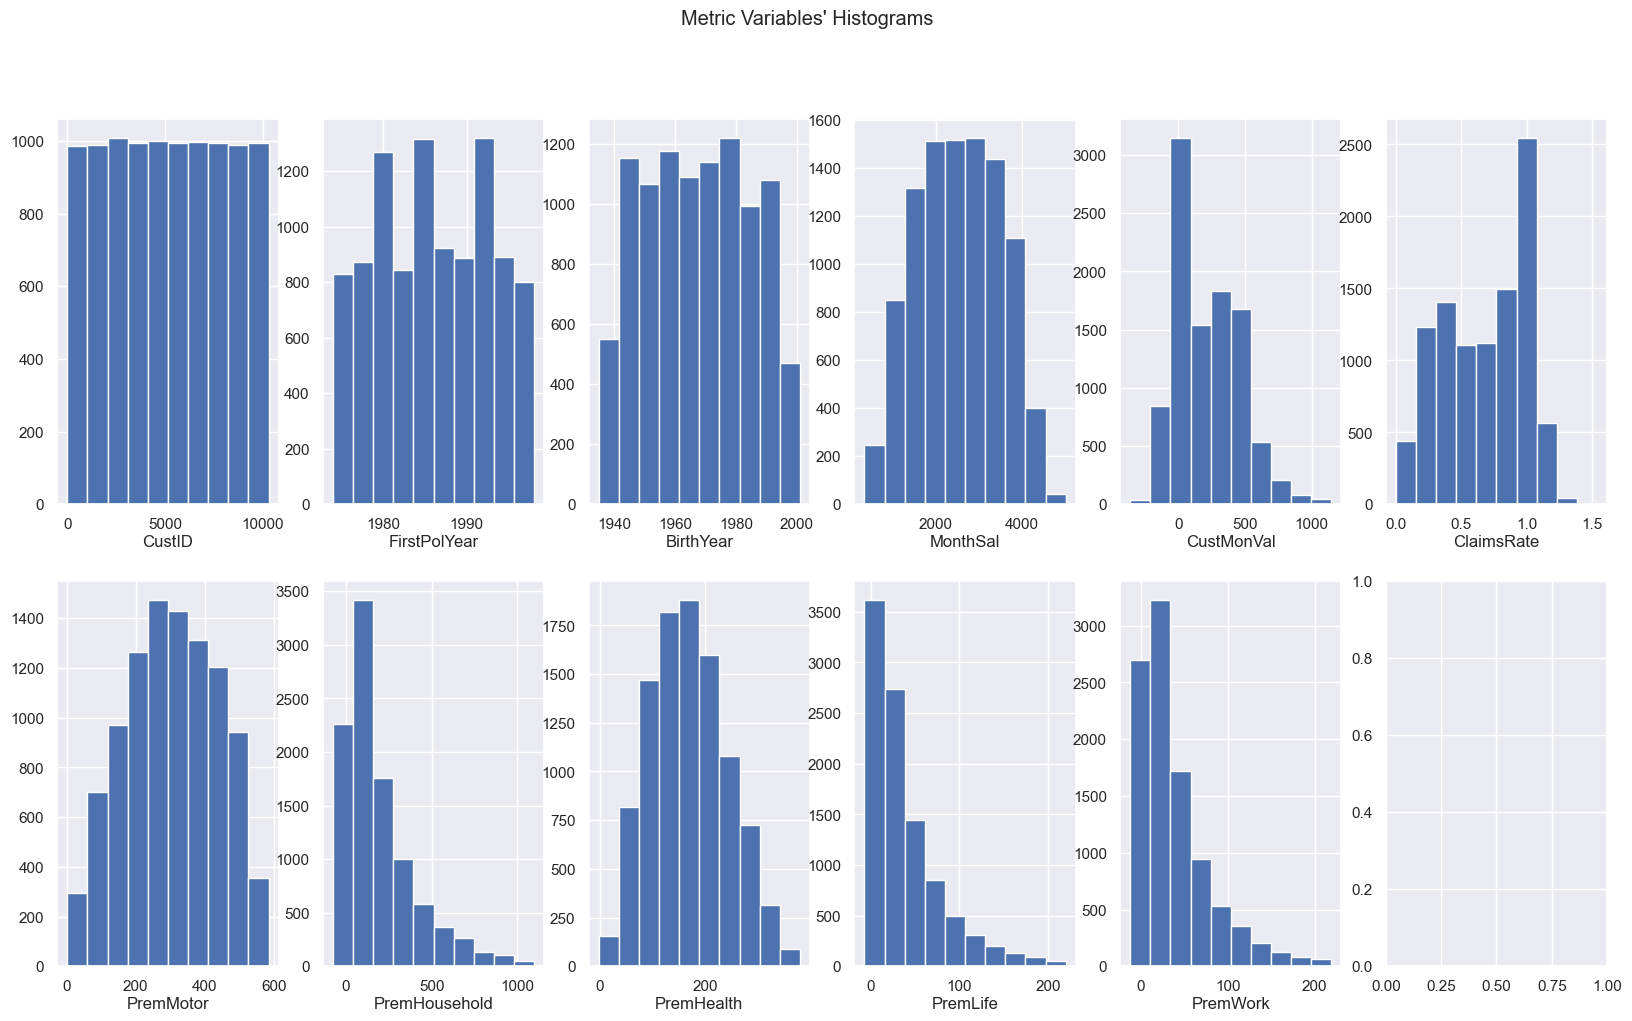

In [25]:
# Check all the histograms from our metric features after outlier removal.

# All Metric Variables' Histograms in one figure.
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df_3[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

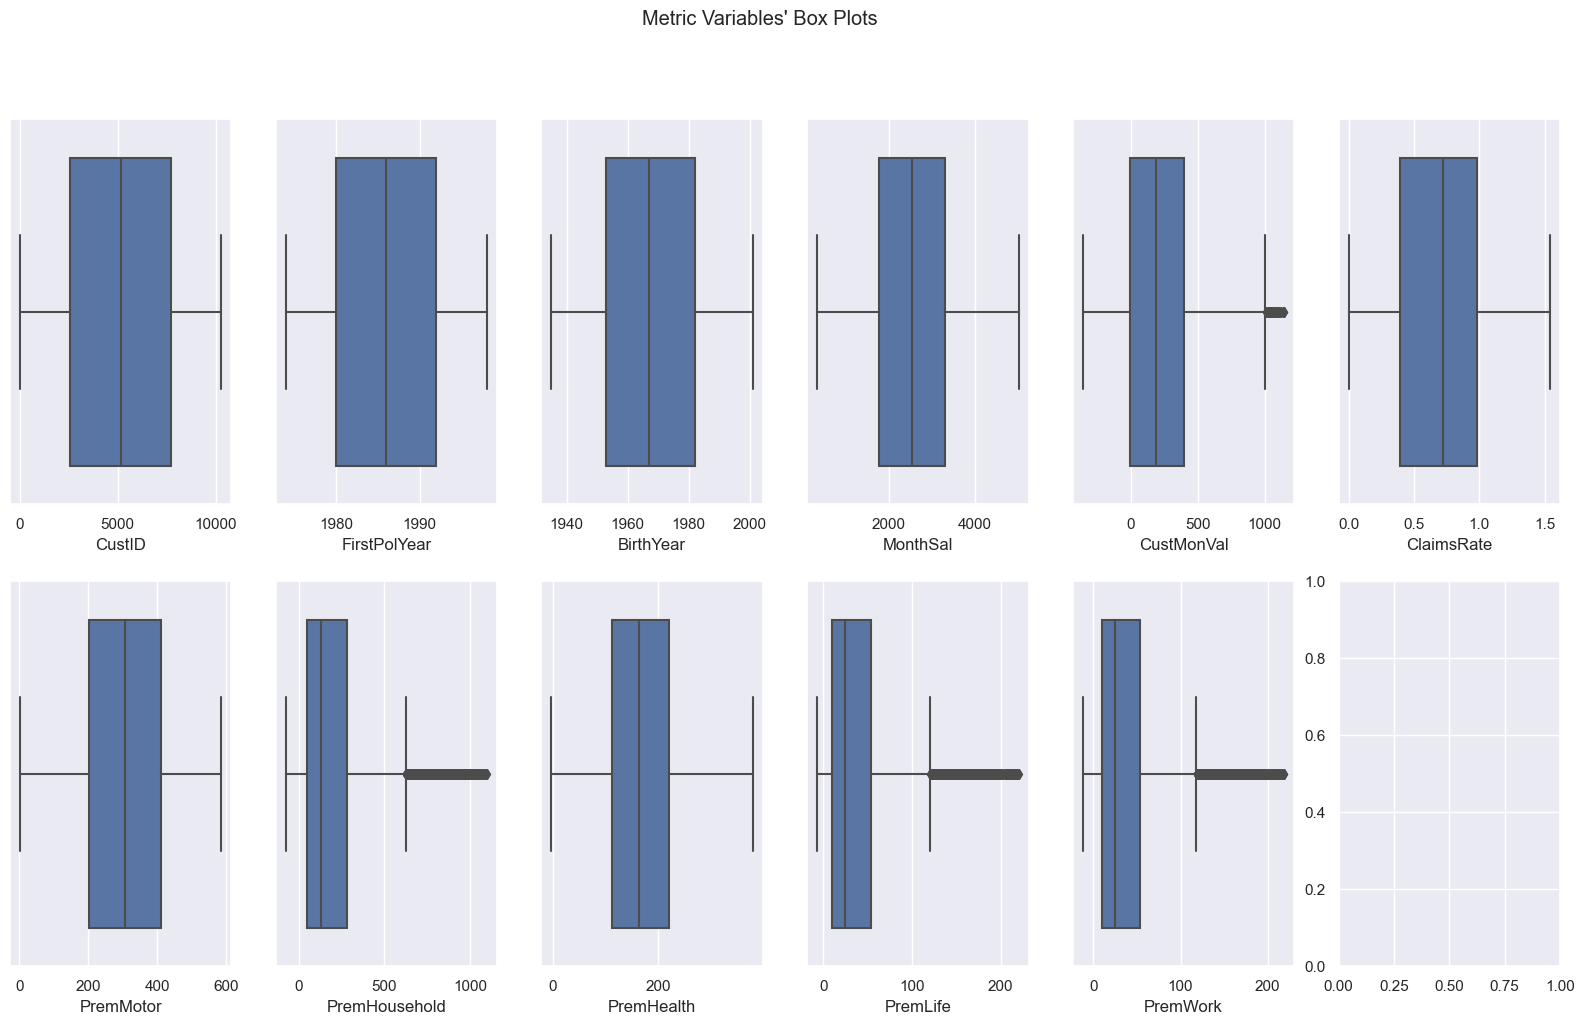

In [26]:
# Check all the box-plots from our metric features after outlier removal.

# All Metric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

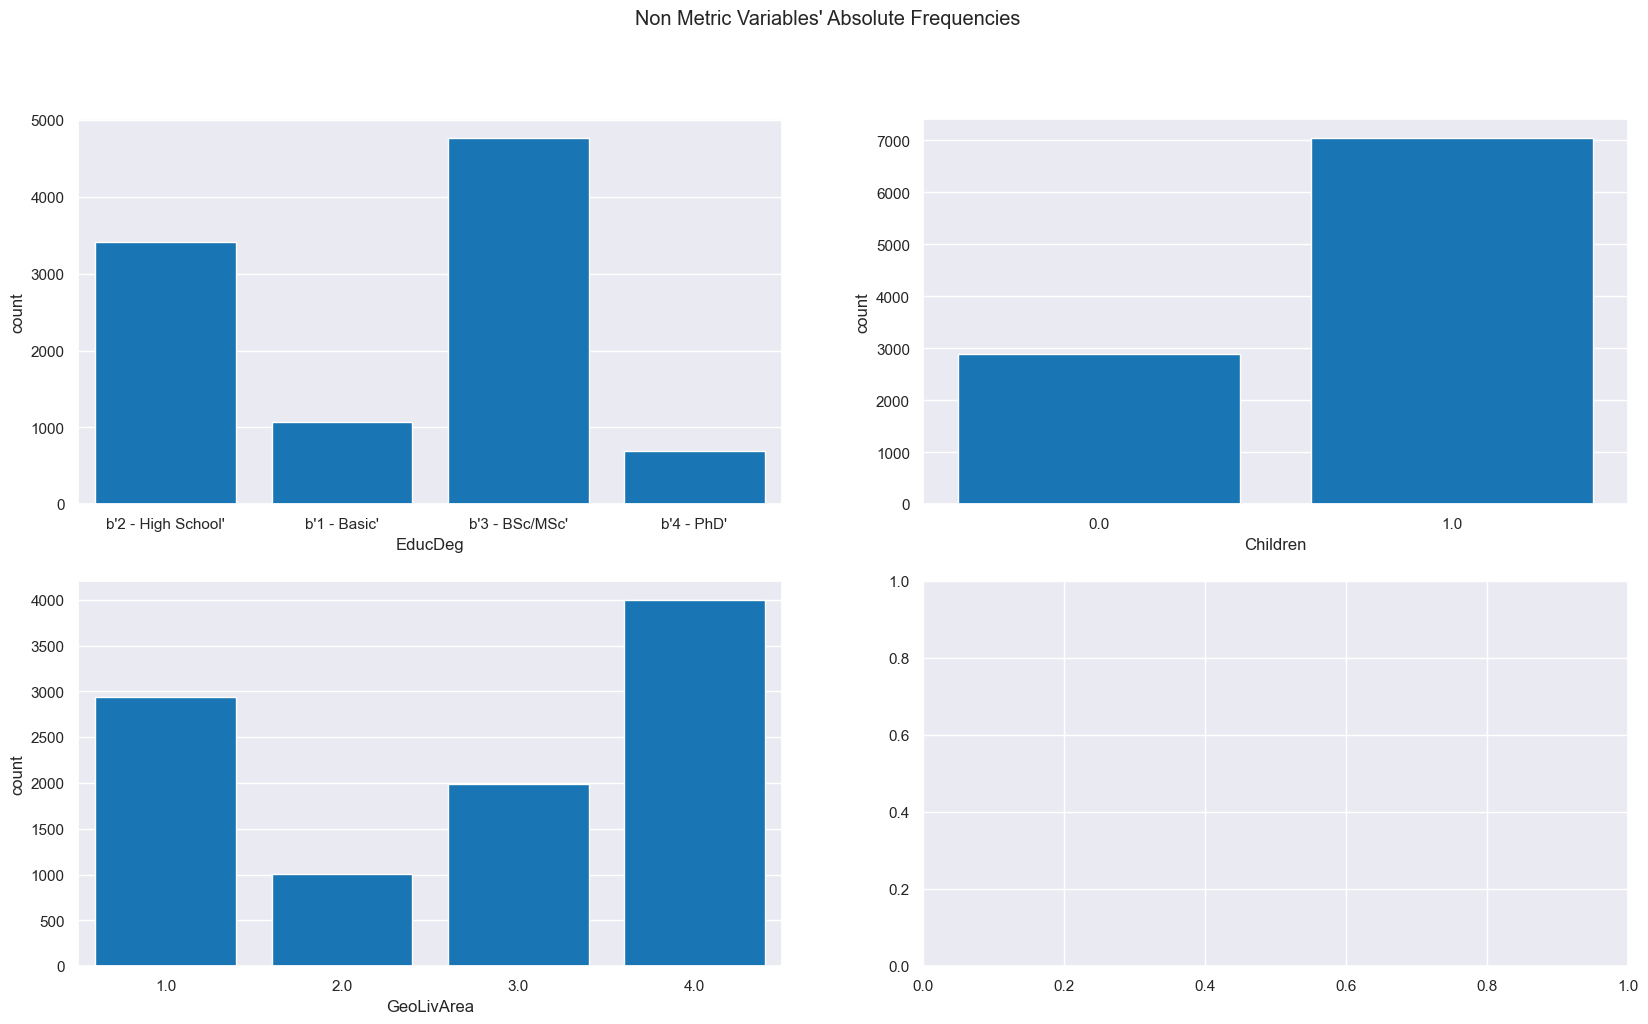

In [27]:
# Check all the histograms from our 'non_metric' features after outlier removal.

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat].astype(object), ax=ax, color='#007acc')

title = "Non Metric Variables' Absolute Frequencies"
plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

# **4. Feature Engineering**

- **4.1) Variable selection: Redundancy vs Relevancy**
- **4.1.1) Redundancy**
- 4.1.1.1) Feature Creation
- 4.1.1.2) Metric Variables Correlation Matrix
- **4.1.2) Relevancy**
- **4.2) One Hot Enconding**
- **4.3) Data Normalization**

In [28]:
# Redundancy:
    # "(...) An attribute (column or feature of data set) is called redundant if it can be derived from 
    # any other attribute or set of attributes.(...)"
# We have added the following 2 variables: 'Age' and 'PolicyAge'.
# Create relevant features after our group reflection.

df['Age'] = 2016 - df['BirthYear']
df['PolicyAge'] = 2016 - df['FirstPolYear'] 

df.head(10)

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,PolicyAge
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.0,31.0
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.0,35.0
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.0,25.0
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.0,26.0
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.0,30.0
5,6.0,1986.0,1956.0,b'2 - High School',2566.0,4.0,1.0,-24.33,1.00,440.75,18.90,114.80,7.00,7.67,60.0,30.0
6,7.0,1979.0,1943.0,b'2 - High School',4103.0,4.0,0.0,-66.01,1.05,156.92,295.60,317.95,14.67,26.34,73.0,37.0
7,8.0,1988.0,1974.0,b'2 - High School',1743.0,4.0,1.0,-144.91,1.13,248.27,397.30,144.36,66.68,53.23,42.0,28.0
8,9.0,1981.0,1978.0,b'3 - BSc/MSc',1862.0,1.0,1.0,356.53,0.36,344.51,18.35,210.04,8.78,9.89,38.0,35.0
9,10.0,1976.0,1948.0,b'3 - BSc/MSc',3842.0,1.0,0.0,-119.35,1.12,209.26,182.25,271.94,39.23,55.12,68.0,40.0


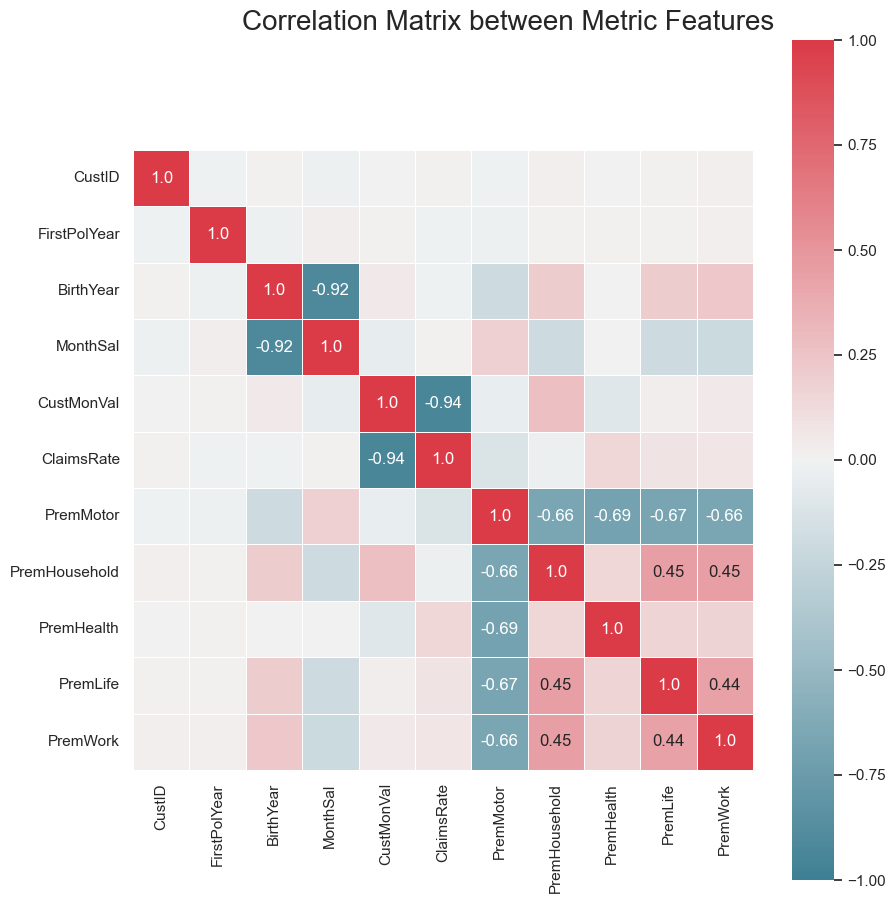

In [29]:
# Check the correlation matrix among the metric features.

# Prepare figure.
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot).
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does.

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix between Metric Features", fontsize=20)

# plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

In [30]:
# Select variables according to their correlations.

df.drop(columns=['BirthYear', 'FirstPolYear', 'CustID'], inplace=True) 

In [31]:
# Update metric_features.

metric_features.remove("BirthYear") # Represented by variable 'Age'.
metric_features.remove("FirstPolYear") # Represented by variable 'PolicyAge'
metric_features.append("Age")
metric_features.append("PolicyAge")

- **4.1) Variable selection: Redundancy vs Relevancy**
- 4.1.2) Relevancy

In [32]:
# Select variables based on the relevancy of each one to the task. 
# We could have removed variables based on two lines of reasoning:
    # Variables that aren't correlated with any other variable;
    # Under our personal judgement, remove based on its significancy.
# We adopted a conservative approach, without removing any variable besides "CustID".

metric_features.remove("CustID") # Not necessary to include in correlation matrix. Does not bring relevant information.

metric_features

['MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age',
 'PolicyAge']

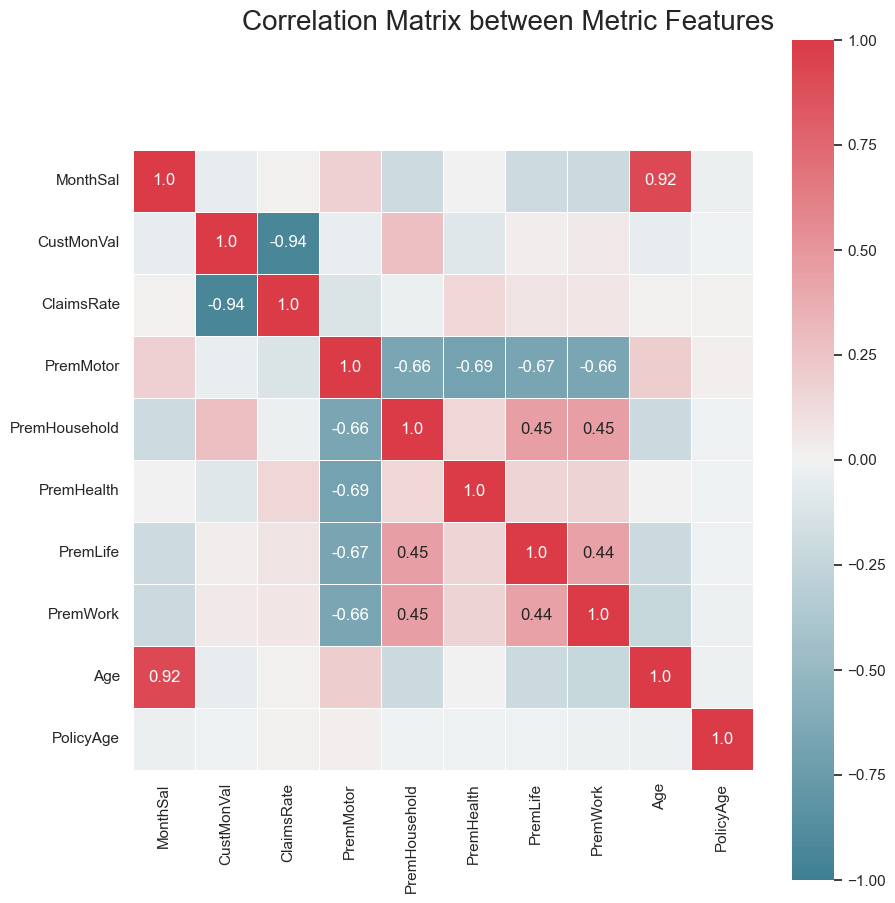

In [33]:
# Check the correlation matrix again after updating metric features.

# Prepare figure.
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot).
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does.

# Plot heatmap of the correlation matrix.
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix between Metric Features", fontsize=20)

# plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

- **4.2) One Hot Enconding**

In [34]:
# Create a safety copy of our dataset before applyng one hot encoding.

df_ohc = df.copy()

In [35]:
# Use 'OneHotEncoder' to encode the categorical features. 
# Get feature names and create a DataFrame by 'OneHotEncoding' categorical features (pass feature names).

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names) 
ohc_df

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_b'1 - Basic',x0_b'2 - High School',x0_b'3 - BSc/MSc',x0_b'4 - PhD',x1_0.0,x1_1.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
10290,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10291,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10294,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [36]:
# Reassign df to contain ohc variables.

df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,PolicyAge,x0_b'1 - Basic',x0_b'2 - High School',x0_b'3 - BSc/MSc',x0_b'4 - PhD',x1_0.0,x1_1.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0
0,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.0,31.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.0,35.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.0,26.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [37]:
# Retake the original dataset for a cleaner interpretation.

df = df_ohc.copy()
df.head()

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,PolicyAge,x0_b'1 - Basic',x0_b'2 - High School',x0_b'3 - BSc/MSc',x0_b'4 - PhD',x1_0.0,x1_1.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0
0,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.0,31.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.0,35.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.0,26.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


- **4.3) Data Normalization**

In [38]:
# Make a second security copy of our dataset before normalization.

df_before_scaling = df.copy(deep=True)

In [39]:
# Use 'StandardScaler' to scale the data. Altough we also tried 'MinMax' scaler, we have obtained better results with
# 'StandardScaler'.

scaler_SS = StandardScaler()
scaled_feat_SS = scaler_SS.fit_transform(df[metric_features])
scaled_feat_SS

array([[-0.36573482,  0.68374754, -0.91595895, ..., -0.52163325,
        -0.85355121,  0.15632936],
       [-1.91718332, -1.41823673,  1.39822576, ...,  1.66843945,
        -1.61727419,  0.76193936],
       [-0.26230492,  1.19149106, -1.26467172, ...,  1.49395025,
        -0.14857615, -0.75208565],
       ...,
       [ 0.40068074,  1.27124414, -1.48657984, ..., -0.81612981,
        -0.50106368, -1.20629315],
       [-0.57880042,  0.14636856, -0.09172878, ...,  1.83483001,
        -0.5598116 ,  0.76193936],
       [ 0.29414794,  1.02352934, -1.29637288, ..., -0.61979877,
        -0.79480329, -0.60068315]])

In [40]:
# Updat our dataframe.

df[metric_features] = scaled_feat_SS
df.head()

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,PolicyAge,x0_b'1 - Basic',x0_b'2 - High School',x0_b'3 - BSc/MSc',x0_b'4 - PhD',x1_0.0,x1_1.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0
0,-0.365735,0.683748,-0.915959,0.536907,-0.544527,-0.305702,0.198950,-0.521633,-0.853551,0.156329,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,-1.917183,-1.418237,1.398226,-1.694840,1.054968,-0.710036,3.777013,1.668439,-1.617274,0.761939,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.262305,1.191491,-1.264672,-0.732329,0.144432,-0.602513,1.153456,1.493950,-0.148576,-0.752086,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.480709,-0.949734,0.986111,-0.909364,-0.715995,1.940278,-0.084199,-0.240634,-0.794803,-0.600683,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.793935,-0.735389,0.700800,0.258453,-0.694858,0.188029,-0.485994,0.081103,-0.324820,0.004927,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
# Check descriptive statistics again after normalization (rounded to 3 decimal places).

df[metric_features].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
MonthSal,9948.0,0.0,1.0,-2.273,-0.794,0.006,0.799,2.576
CustMonVal,9948.0,-0.0,1.0,-2.361,-0.914,-0.112,0.751,3.829
ClaimsRate,9948.0,-0.0,1.0,-2.152,-0.916,0.130,0.954,2.730
PremMotor,9948.0,-0.0,1.0,-2.261,-0.761,0.016,0.795,2.103
PremHousehold,9948.0,0.0,1.0,-1.278,-0.690,-0.310,0.406,4.296
PremHealth,9948.0,-0.0,1.0,-2.329,-0.762,-0.065,0.697,2.876
PremLife,9948.0,0.0,1.0,-1.111,-0.702,-0.343,0.371,4.395
PremWork,9948.0,0.0,1.0,-1.231,-0.691,-0.314,0.370,4.439
Age,9948.0,0.0,1.0,-1.970,-0.854,0.028,0.850,1.908
PolicyAge,9948.0,-0.0,1.0,-1.822,-0.903,0.005,0.913,1.822


# **5. K-Means Clustering**

- **5.1) Defining the number of clusters**
- 5.1.1) Inertia
- 5.1.2) Sillhouete Coefficient
- **5.2) Final Clustering Solution**
- **5.3) Key Conclusions**
- **5.4) Assessing using R2**
- **5.5) Cluster Visualization using Tsne**

- **5.1) Defining the number of clusters**

- 5.1.1) Inertia

In [42]:
# Define the range of our clustering analysis.

range_clusters = range(1, 11)

In [43]:
# For loop for inertia. 
# Inertia measures how well a dataset was clustered. Lower values of inertia means better results.

inertia = []
for n_clus in range_clusters:  # Iterate over desired ncluster range (defined in the cell above).
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)

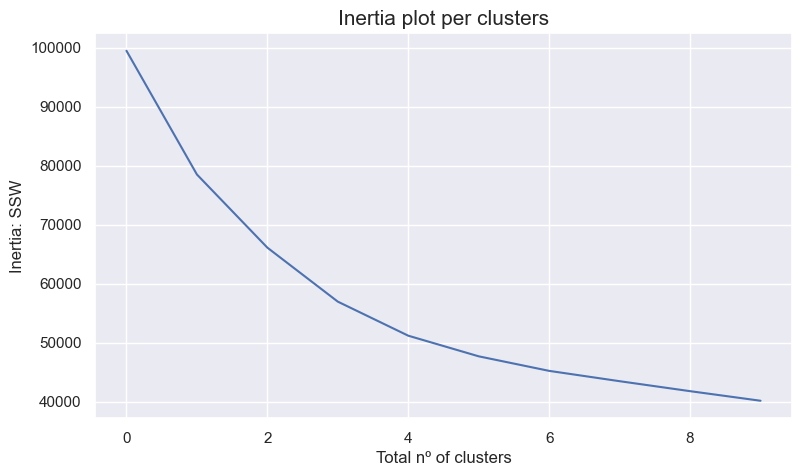

In [44]:
# By observing the elbow method, we should opt for a value between 3 and 5 clusters.
# We opted for defined the number of clusters as 4.
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSW")
plt.xlabel("Total nº of clusters")
plt.title("Inertia plot per clusters", size=15)
plt.show()

- 5.1.2) Sillhouete Coefficient

For n_clusters = 2, the average silhouette_score is : 0.23261252475644884
For n_clusters = 3, the average silhouette_score is : 0.19877546694547624
For n_clusters = 4, the average silhouette_score is : 0.21195155880242553
For n_clusters = 5, the average silhouette_score is : 0.21342810301676918
For n_clusters = 6, the average silhouette_score is : 0.2195888958448201
For n_clusters = 7, the average silhouette_score is : 0.20633036767103524
For n_clusters = 8, the average silhouette_score is : 0.19730341623053796
For n_clusters = 9, the average silhouette_score is : 0.18599081537954468
For n_clusters = 10, the average silhouette_score is : 0.16797537720049327


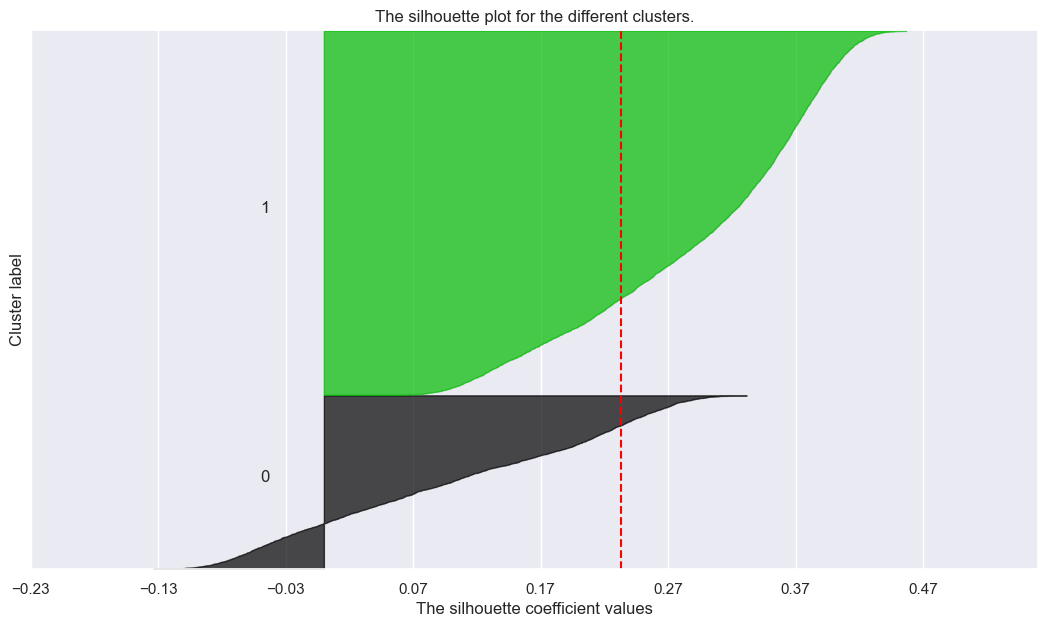

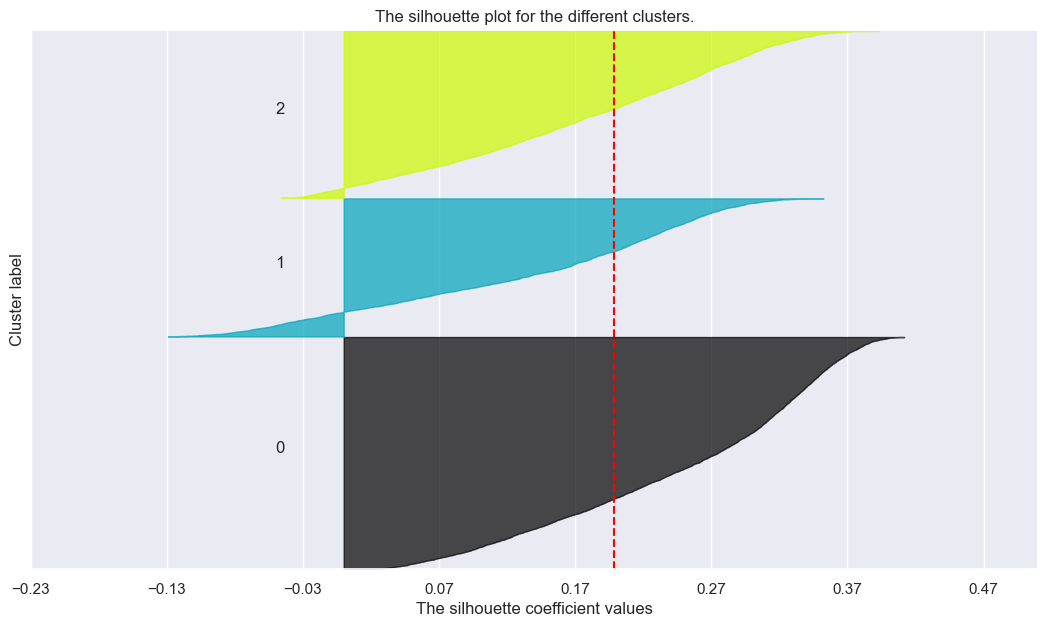

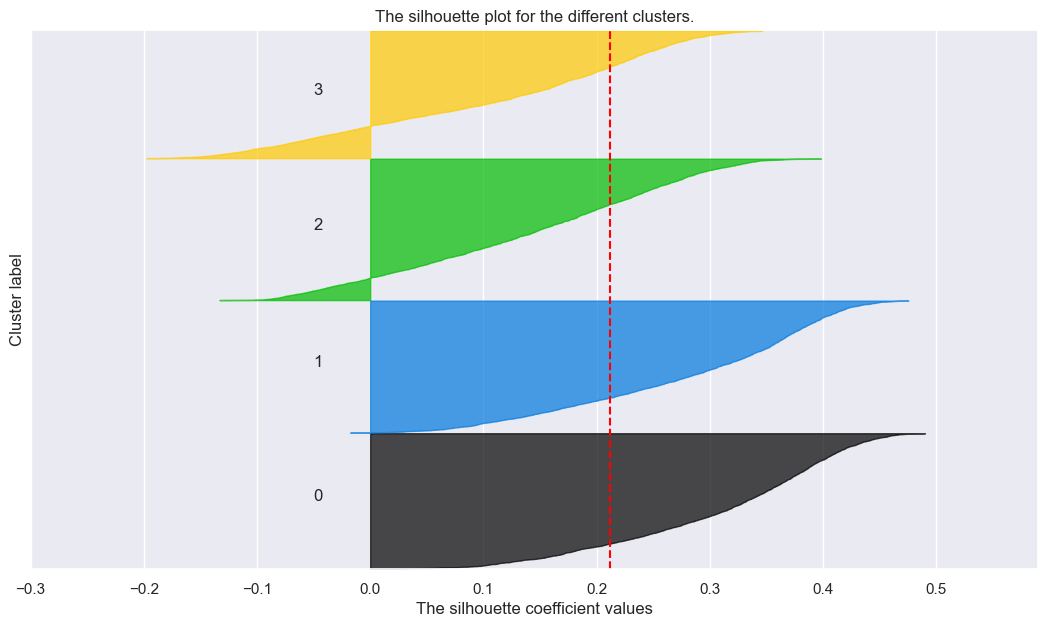

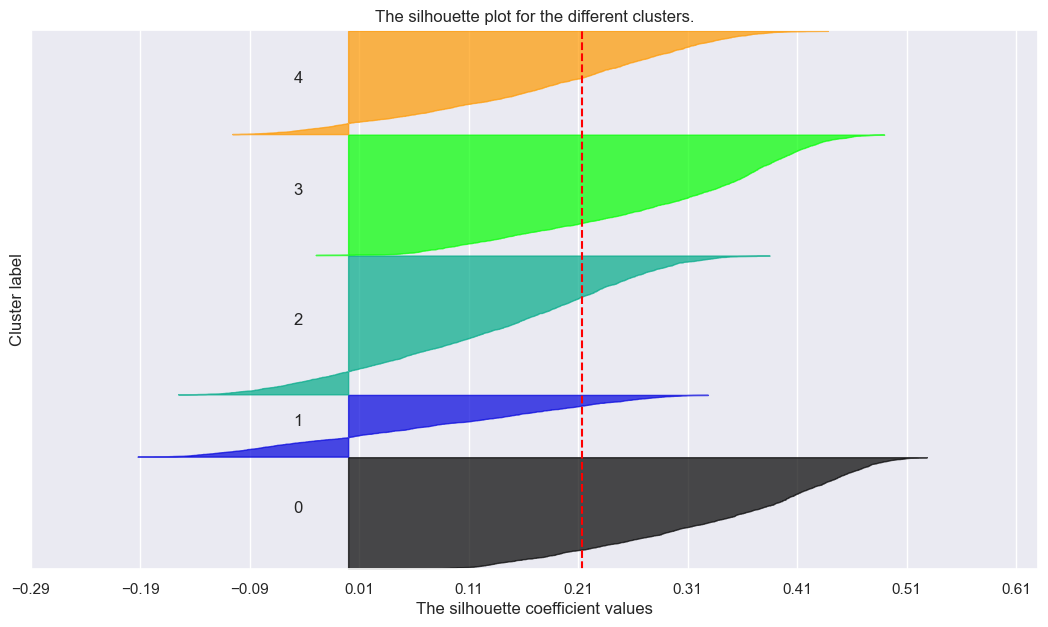

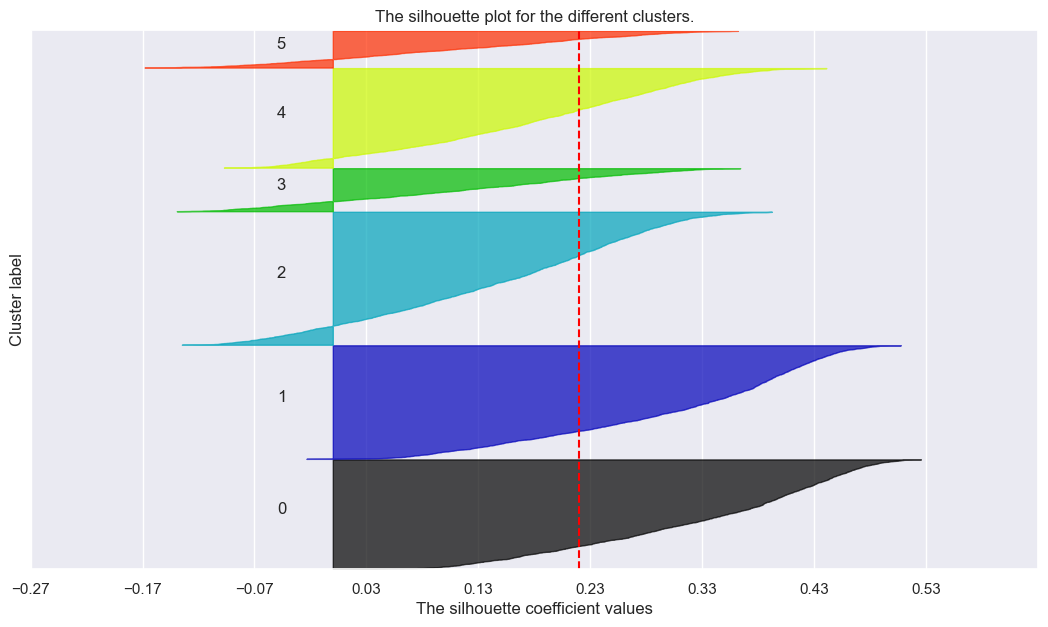

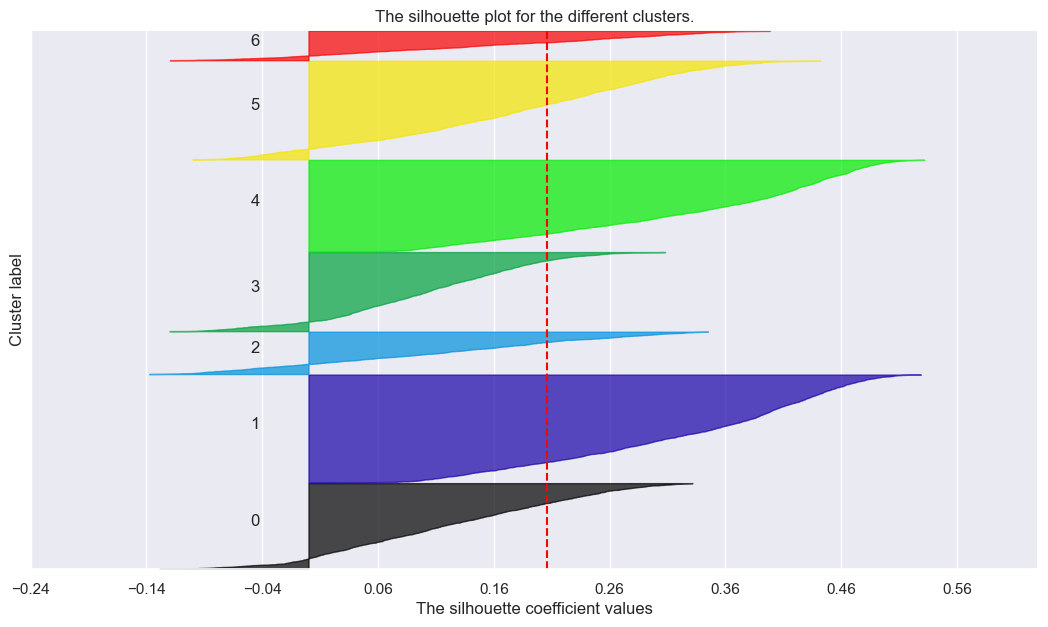

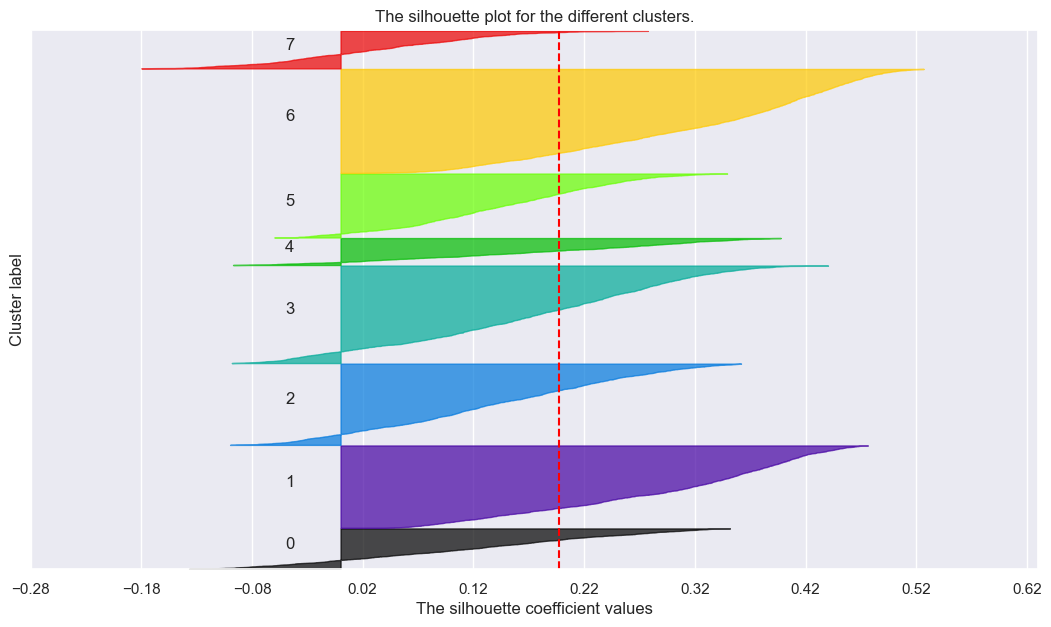

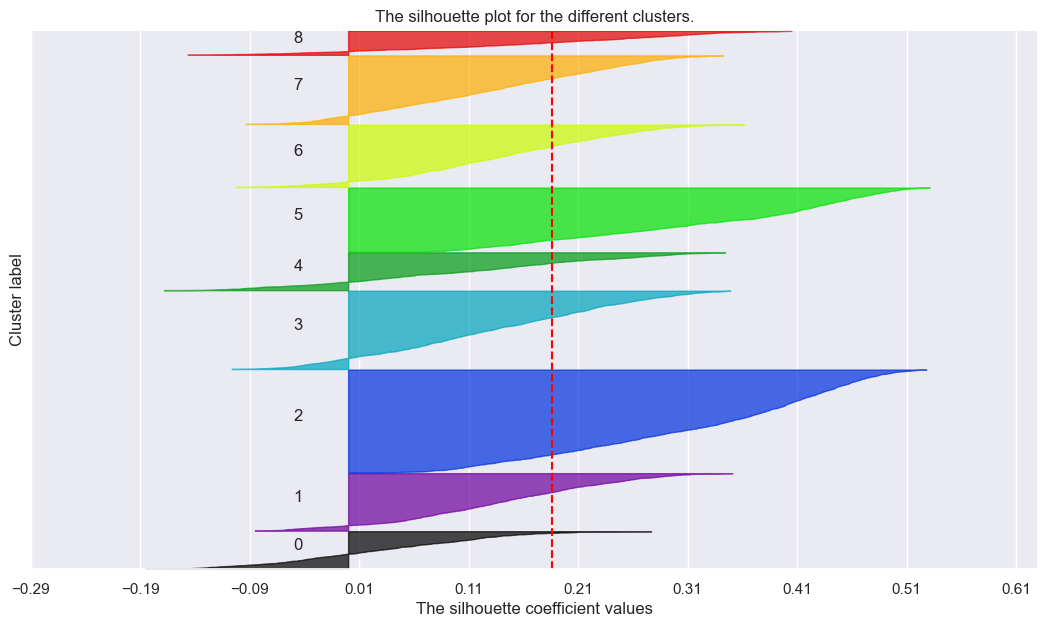

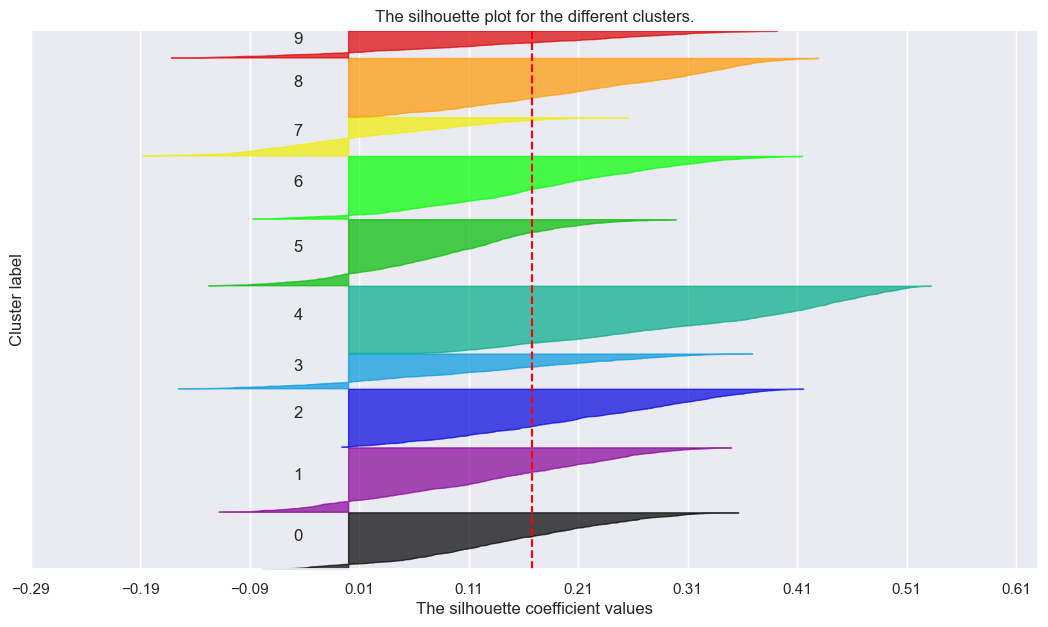

In [45]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Store average silhouette metric.
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the different clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

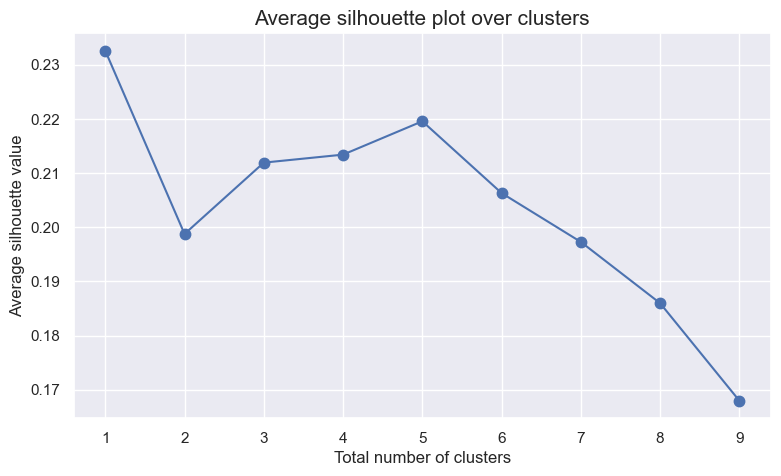

In [46]:
# Draw the average silhouette plot.

plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=15)
plt.ylabel("Average silhouette value")
plt.xlabel("Total number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

- **Observations from Inertia:**
    - By analyzing Inertia graphing, under "Elbow Method", we get to the conclusion that the ideal number of clusters is 4, as long as it presents the lower SSW.
    
    
- **Observations from Silhouette:**    
    - Silhouette tends to start with the highest value, with 1 cluster;
    - Then, it decreases until at 2 clusters and increases again from 2 to 5 clusters, meaning that on average, our observations are better representated with this number of clusters, than the other.
    
    
- **Inertia vs Silhouette:**
    - Our goal is to achieve a small inertia value and a high silhouete value.
    - After discussing, we opted to follow Inertia conclusions, adopting 4 clusters as our final solution.

- **5.2) Final Clustering Solution**
- 5.2.1 Defining the number of clusters and respective labels
- 5.2.2 Getting the final means per variable before and after scaling 

In [47]:
# Our Final cluster solution.

number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
df_km_labels = kmclust.fit_predict(df[metric_features])
df_km_n_clusters = len(np.unique(df_km_labels))
print("Number of estimated kmeans clusters : %d" % df_km_n_clusters)

Number of estimated kmeans clusters : 4


In [48]:
# Characterize the final clusters (after Scalling).

df_kmeans = pd.concat((df, pd.Series(df_km_labels, index=df.index, name='df_km_labels')), axis=1)
df_kmeans_mean = df_kmeans.groupby('df_km_labels').mean()

In [49]:
# Characterize the final clusters (before Scalling).

df_before_scaling_kmeans = pd.concat((df_before_scaling, pd.Series(df_km_labels, index=df_before_scaling.index, name='df_km_labels')), axis=1)
df_before_scaling_kmeans_mean = df_before_scaling_kmeans.groupby('df_km_labels').mean()
df_before_scaling_kmeans_mean

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,PolicyAge,x0_b'1 - Basic',x0_b'2 - High School',x0_b'3 - BSc/MSc',x0_b'4 - PhD',x1_0.0,x1_1.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0
df_km_labels,,,,,,,,,,,,,,,,,,,,
0,3555.281265,188.455131,0.729832,230.356393,237.381543,216.339634,48.231102,46.378901,67.173089,29.634554,0.107048,0.409143,0.440381,0.043429,0.704000,0.296000,0.280381,0.106667,0.191238,0.421714
1,1427.770087,247.197160,0.700354,159.503005,375.357228,206.525007,74.051393,73.908822,28.240665,29.885091,0.235394,0.443497,0.303625,0.017484,0.163326,0.836674,0.306183,0.095949,0.200426,0.397441
2,2497.376482,-7.112938,0.977137,412.865467,74.473171,126.983136,16.783381,16.566695,47.989893,30.189687,0.047450,0.268090,0.580071,0.104389,0.125346,0.874654,0.294187,0.106366,0.208383,0.391064
3,2522.610814,439.516133,0.295929,409.135895,97.650470,124.872999,17.714202,17.358519,48.528699,30.173669,0.049408,0.252348,0.585953,0.112291,0.140874,0.859126,0.303797,0.096366,0.202123,0.397713


- **5.3) Key Conclusions**

In [50]:
# Compute the transpose (after scalling for the sake of an easier interpretation).

df_kmeans_meanT = df_kmeans_mean.T
df_kmeans_meanT

df_km_labels,0,1,2,3
MonthSal,1.059820,-1.140663,-0.034370,-0.008270
CustMonVal,-0.106456,0.134659,-0.909192,0.924058
ClaimsRate,0.161349,0.067899,0.945334,-1.214175
PremMotor,-0.551283,-1.081216,0.813757,0.785863
PremHousehold,0.205616,0.860973,-0.568166,-0.458078
PremHealth,0.647959,0.514208,-0.569764,-0.598521
PremLife,0.228578,0.855055,-0.534438,-0.511853
PremWork,0.202065,0.877687,-0.529568,-0.510135
Age,1.095299,-1.191900,-0.031674,-0.000020
PolicyAge,-0.050403,-0.012471,0.033646,0.031221


In [51]:
# Compute the transpose (before scalling for the sake of an easier interpretation).

df_before_scaling_kmeansT = df_before_scaling_kmeans_mean.T
df_before_scaling_kmeansT

df_km_labels,0,1,2,3
MonthSal,3555.281265,1427.770087,2497.376482,2522.610814
CustMonVal,188.455131,247.197160,-7.112938,439.516133
ClaimsRate,0.729832,0.700354,0.977137,0.295929
PremMotor,230.356393,159.503005,412.865467,409.135895
PremHousehold,237.381543,375.357228,74.473171,97.650470
PremHealth,216.339634,206.525007,126.983136,124.872999
PremLife,48.231102,74.051393,16.783381,17.714202
PremWork,46.378901,73.908822,16.566695,17.358519
Age,67.173089,28.240665,47.989893,48.528699
PolicyAge,29.634554,29.885091,30.189687,30.173669


- **Cluster 0**: 
    - The mean of ages is equal to 67.
    - The highest PremHousehold
    - There is not a tendency for having children.
    
- **Cluster 1**: 
    - The mean of ages is equal to 28.
    - The highest PremHousehold
    - The lowest PremMotor
    - High tendency for having children.
    
- **Cluster 2**: 
    - The mean of ages is equal to 47.
    - The lowest customer monetary value.
    - The highest claims rate.
    - The lowest PremHousehold
    - High tendency for having children.

- **Cluster 3**: 
    - The mean of ages is equal to 48.
    - The highest value of customer monetary value.
    - The highest claims rate
    - The highest PremMotor
    - The lowest PremHousehold
    - High tendency for having children.

- **5.4) Assessing using R2**

- 5.4.1) Defining SS functions

In [52]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var()*(df.count() - 1))
    return ss  # Return sum of sum of squares of each df variable.

In [53]:
def get_ss_feature(df):
    """Get the SS for each variable
    """
    ss_vars = df.var()*(df.count() - 1)
    return ss_vars

- 5.4.2) Defining r2 functions

In [54]:
def get_r2(df, labels):
    sst = get_ss(df) # Get total sum of squares.
    ssw_labels = df.groupby(by=labels).apply(get_ss)  # Compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # Remember: SST = SSW + SSB.
    r2 = ssb / sst
    return r2

In [55]:
def get_r2_feature(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_feature(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_feature))
    return 1 - ssw_vars/sst_vars

In [56]:
# First, we are assessing our clustering solution by using R²:

df_kmeans_r2 =  get_r2(df_kmeans, "df_km_labels")
print("Kmeans Cluster final solution with R² of %0.4f" % df_kmeans_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_kmeans[metric_features + ['df_km_labels']], 'df_km_labels').drop('df_km_labels').sort_values(axis=0, ascending=False)

Kmeans Cluster final solution with R² of 0.4373


PremMotor        0.676146
Age              0.651695
MonthSal         0.603409
ClaimsRate       0.598067
CustMonVal       0.427621
PremHealth       0.343832
PremWork         0.327722
PremLife         0.323240
PremHousehold    0.319617
PolicyAge        0.001235
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.4373.
    - The three variables that mostly contribute to the this R2 value are: PremMotor, Age and MonthSal, all above 0.6.

- **5.5) Cluster Visualization using Tsne**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


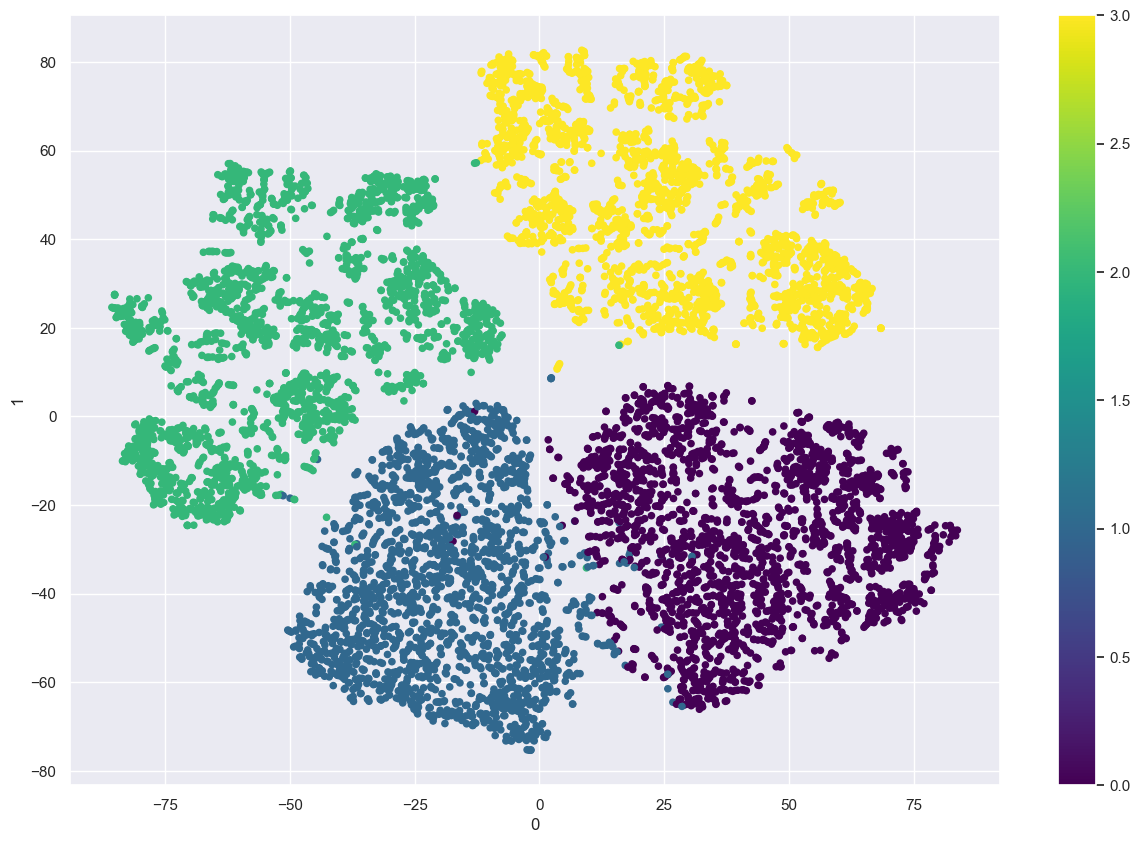

In [57]:
df_kmeans_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df_kmeans)
pd.DataFrame(df_kmeans_tsne).plot.scatter(x=0, y=1, c = df_kmeans['df_km_labels'], colormap='viridis', figsize=(15,10))
plt.show()